In [1]:
from typing import List, Iterable

import numpy as np
import matplotlib.pyplot as plt
import abc

import numpy as np
import pandas as pd
from numpy import linalg
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import time

## Градиентный спуск

In [2]:
class BaseLoss(abc.ABC):
    @abc.abstractmethod
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        raise NotImplementedError

    @abc.abstractmethod
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        raise NotImplementedError

Реализация класса `MSELoss`

Он вычисляет лосс и градиент по следующим формулам: 

$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2
$$


$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2
$$

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y)
$$

In [3]:
class MSELoss(BaseLoss):
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        Q = (linalg.norm(np.dot(X, w) - y)**2) * 1/len(y)
        return Q

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        L = np.dot(X, w) - y
        Xt = np.transpose(X)
        Grad = np.dot(Xt, L) * 2/len(y)
        return Grad

In [4]:
# Создадим объект лосса
loss = MSELoss()

# Создадим какой-то датасет
X = np.arange(200).reshape(20, 10)
y = np.arange(20)

# Создадим какой-то вектор весов
w = np.arange(10)

# Выведем значение лосса и градиента на этом датасете с этим вектором весов
print(loss.calc_loss(X, y, w))
print(loss.calc_grad(X, y, w))

# Проверка, что методы реализованы правильно
assert loss.calc_loss(X, y, w) == 27410283.5, "Метод calc_loss реализован неверно"
assert np.allclose(loss.calc_grad(X, y, w), np.array([1163180., 1172281., 1181382., 1190483.,
                                                      1199584., 1208685., 1217786., 1226887.,
                                                      1235988., 1245089.])), "Метод calc_grad реализован неверно"
print("Всё верно!")

27410283.5
[1163180. 1172281. 1181382. 1190483. 1199584. 1208685. 1217786. 1226887.
 1235988. 1245089.]
Всё верно!


Реализация функции `gradient_descent`

$$
w^t = w^{t-1} - \eta \nabla_{w} Q(w^{t-1}, X, y)
$$

In [5]:
def gradient_descent(w_init: np.ndarray, X: np.ndarray, y: np.ndarray,
                        loss: BaseLoss, lr: float, n_iterations: int = 100000) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    W = []
    for i in range(n_iterations):
        w_init_new = w_init - lr * loss.calc_grad(X, y, w_init)
        W.append(w_init_new)
        w_init = w_init_new

    return W



In [6]:
# Создаём датасет из двух переменных и реального вектора зависимости w_true

np.random.seed(1337)

n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features, ))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

print(X.shape)
print(y.shape)

(300, 2)
(300,)


Создадим экземпляр класса MSELoss() и посмотрим на ошибку на первом и последнем шаге

In [7]:
loss = MSELoss()

In [8]:
w_list = gradient_descent(w_init=w_init, X=X, y=y, loss=loss, lr=0.01, n_iterations=100)

In [11]:
print(loss.calc_loss(X, y, w_list[0]))
print(loss.calc_loss(X, y, w_list[-1]))

155.26258214351958
0.8670644395649494


In [12]:
def plot_gd(w_list: Iterable, X: np.ndarray, y: np.ndarray, loss: BaseLoss):
    """
    Функция для отрисовки траектории градиентного спуска
    :param w_list: Список из объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать лосс при помощи loss.calc_loss(X, y, w)
    """
    w_list = np.array(w_list)
    meshgrid_space = np.linspace(-2, 2, 100)
    A, B = np.meshgrid(meshgrid_space, meshgrid_space)

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = loss.calc_loss(X, y, w_tmp)

    plt.figure(figsize=(15, 6))
    plt.title("GD trajectory")
    plt.xlabel(r'$w_1$')
    plt.ylabel(r'$w_2$')
    plt.xlim(w_list[:, 0].min() - 0.1,
             w_list[:, 0].max() + 0.1)
    plt.ylim(w_list[:, 1].min() - 0.1,
             w_list[:, 1].max() + 0.1)
    plt.gca().set_aspect('equal')

    # visualize the level set
    CS = plt.contour(A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r)
    CB = plt.colorbar(CS, shrink=0.8, extend='both')

    # visualize trajectory
    plt.scatter(w_list[:, 0], w_list[:, 1])
    plt.plot(w_list[:, 0], w_list[:, 1])

    plt.show()

Графики траекторий градиентного спуска для разных значений длины шага

Длина шага:  0.0001


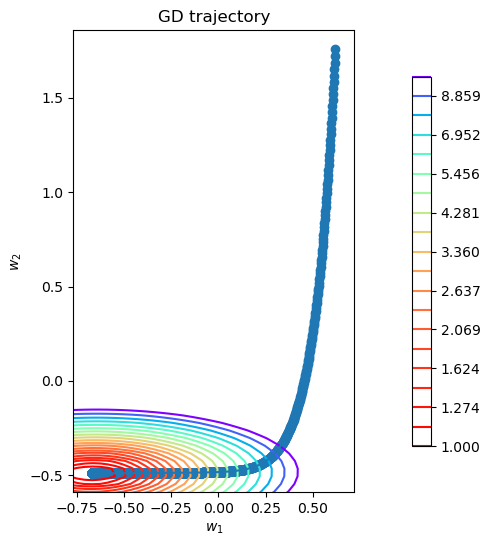

Длина шага:  0.001


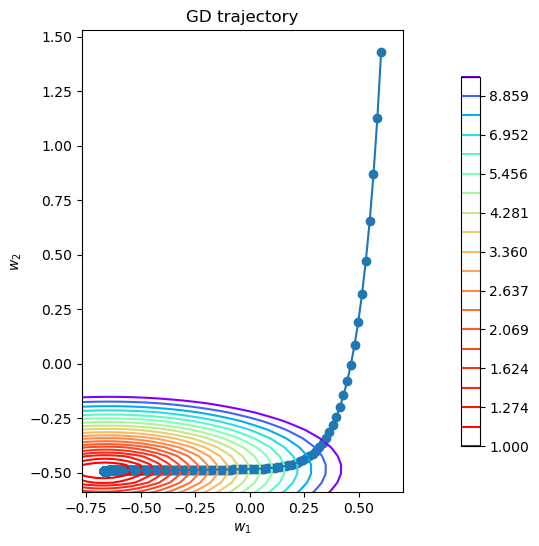

Длина шага:  0.01


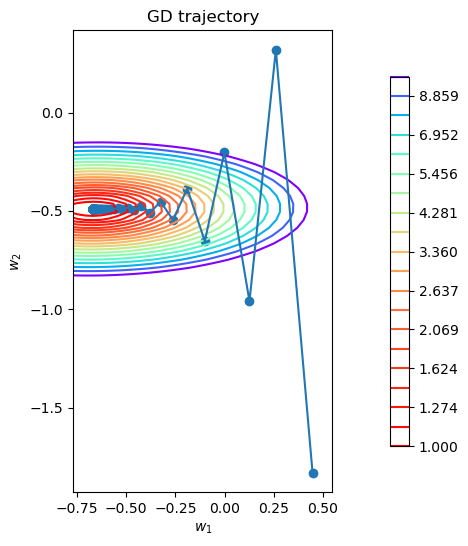

In [14]:
lr = [0.0001, 0.001, 0.01]

for i in lr:
    w_list = gradient_descent(w_init, X, y, loss, i)
    print('Длина шага: ', i)
    plot_gd(w_list, X, y, loss)

Реализация функции `stochastic_gradient_descent`

In [17]:
def stochastic_gradient_descent(w_init: np.ndarray, X: np.ndarray, y: np.ndarray,
                        loss: BaseLoss, lr: float, batch_size: int, n_iterations: int = 1000) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """

    W = []

    for i in range(n_iterations):
        batch_indices = np.random.choice(X.shape[0], size=batch_size)
        X_batch = X[batch_indices]
        y_batch = y[batch_indices]
        w_init_new = w_init - lr*loss.calc_grad(X_batch, y_batch, w_init)
        W.append(w_init_new)
        w_init = w_init_new

    return W

batch_size =  1 , lr =  0.0001
 --- 0.242659330368042 seconds ---


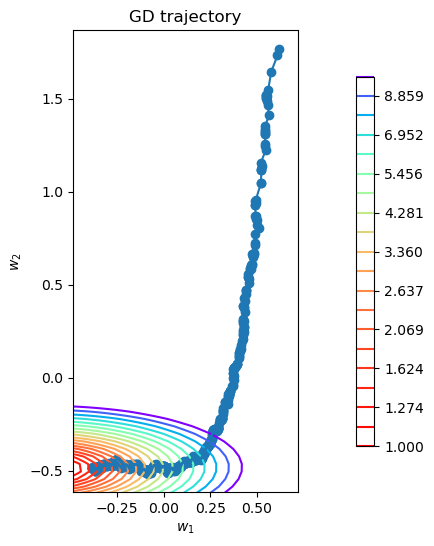

batch_size =  1 , lr =  0.001
 --- 0.18690109252929688 seconds ---


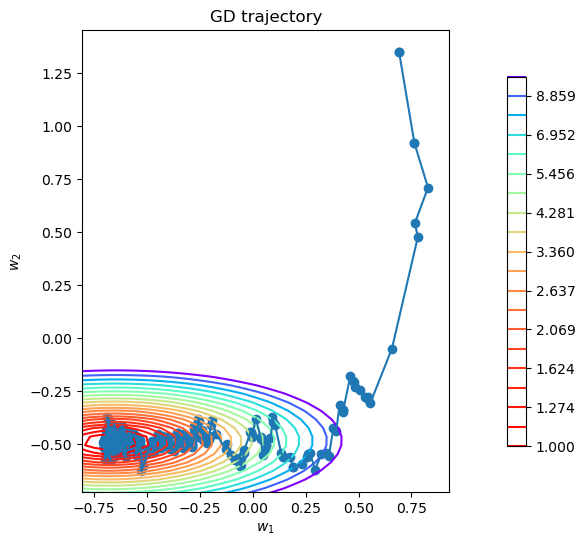

batch_size =  1 , lr =  0.01
 --- 0.4474523067474365 seconds ---


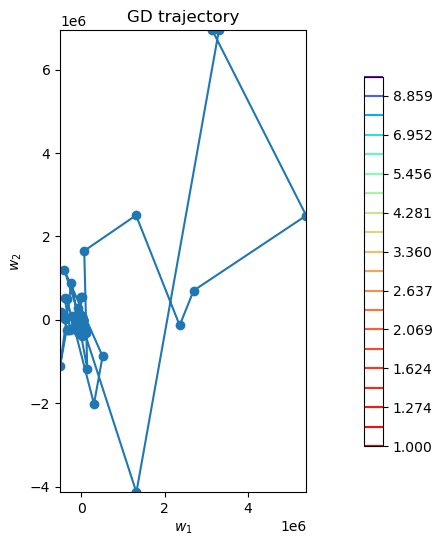

batch_size =  1 , lr =  0.012
 --- 0.2513153553009033 seconds ---


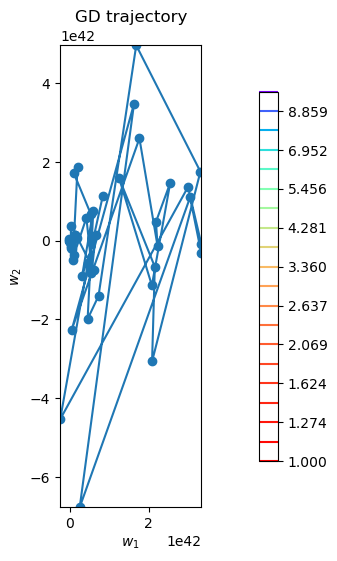

batch_size =  10 , lr =  0.0001
 --- 0.20857858657836914 seconds ---


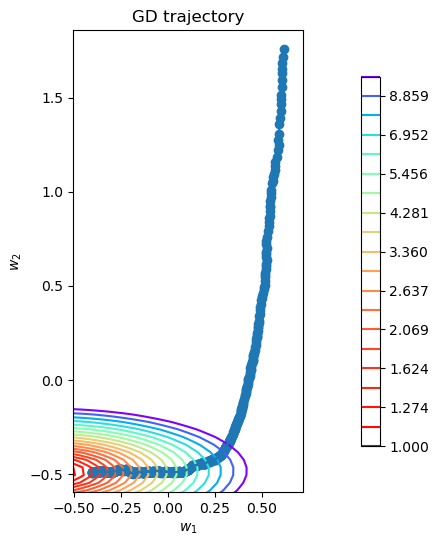

batch_size =  10 , lr =  0.001
 --- 0.32895565032958984 seconds ---


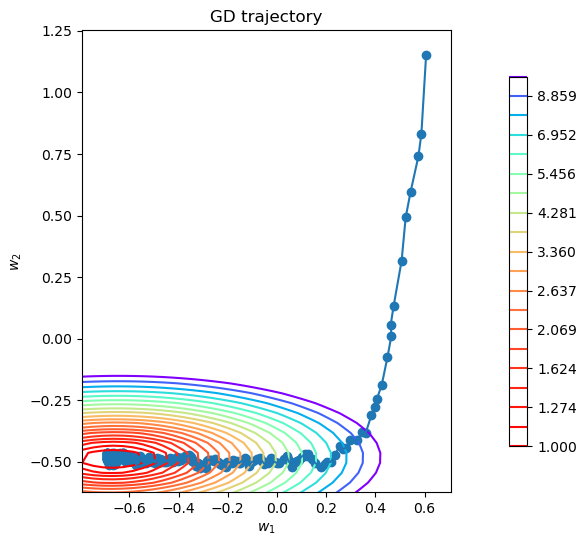

batch_size =  10 , lr =  0.01
 --- 0.2750387191772461 seconds ---


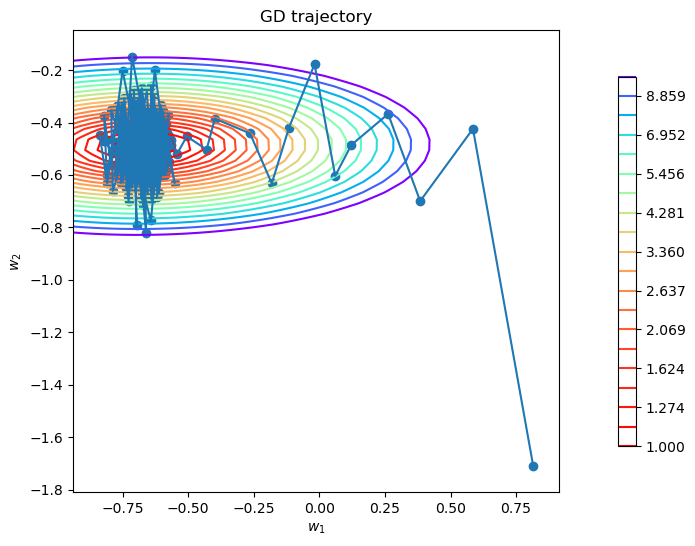

batch_size =  10 , lr =  0.012
 --- 0.3671720027923584 seconds ---


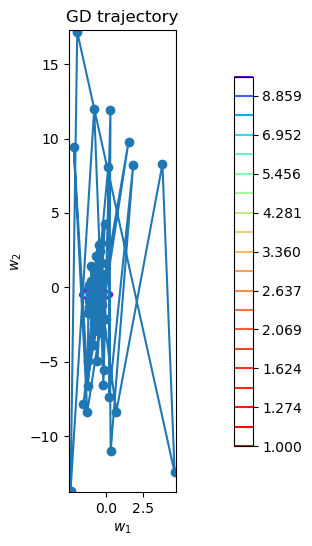

batch_size =  100 , lr =  0.0001
 --- 0.32279038429260254 seconds ---


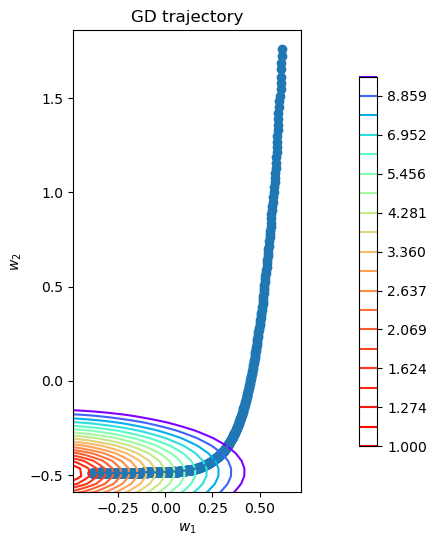

batch_size =  100 , lr =  0.001
 --- 0.5219035148620605 seconds ---


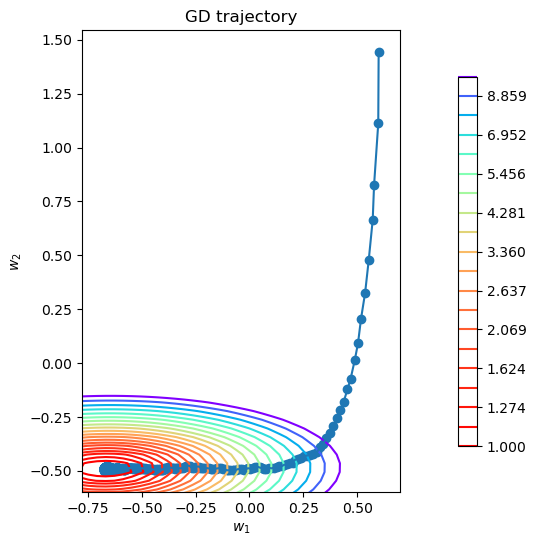

batch_size =  100 , lr =  0.01
 --- 0.19735026359558105 seconds ---


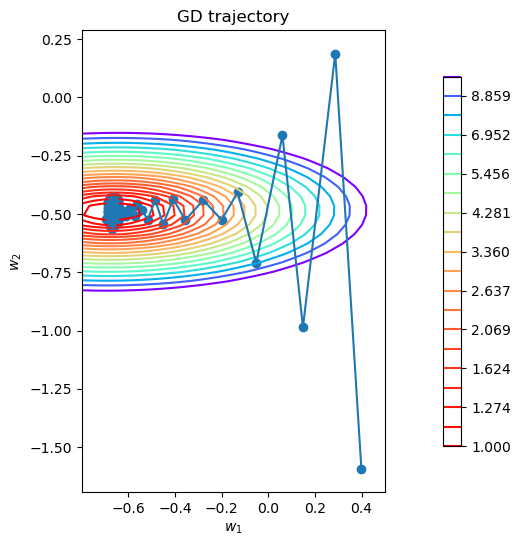

batch_size =  100 , lr =  0.012
 --- 0.2528395652770996 seconds ---


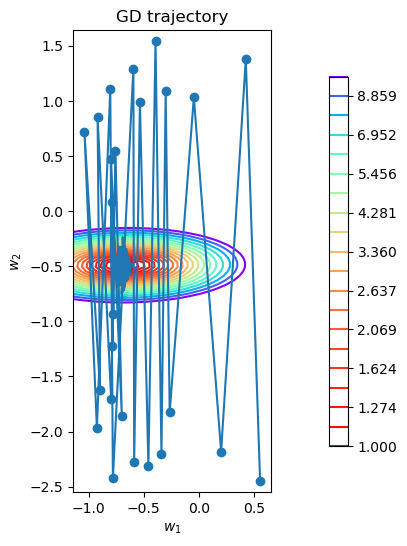

batch_size =  200 , lr =  0.0001
 --- 0.4606783390045166 seconds ---


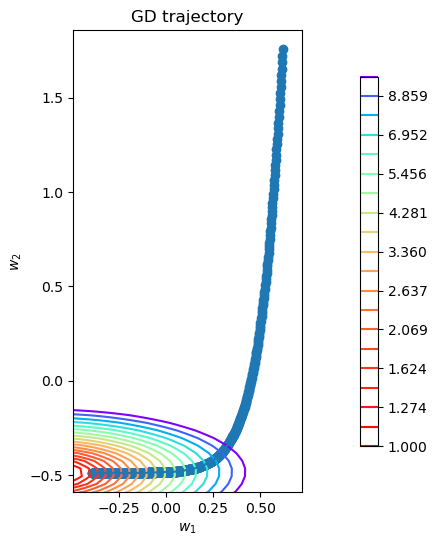

batch_size =  200 , lr =  0.001
 --- 0.5252764225006104 seconds ---


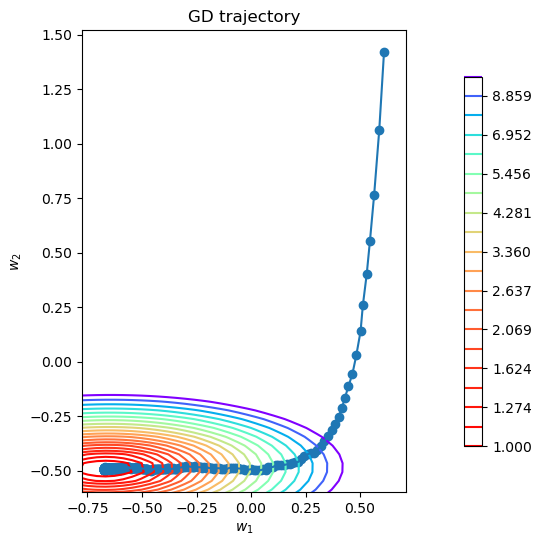

batch_size =  200 , lr =  0.01
 --- 0.3161451816558838 seconds ---


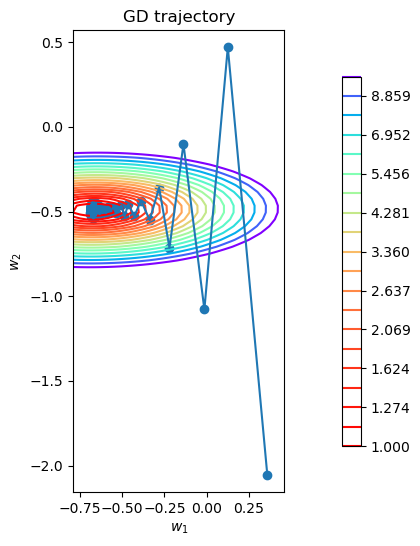

batch_size =  200 , lr =  0.012
 --- 0.30018019676208496 seconds ---


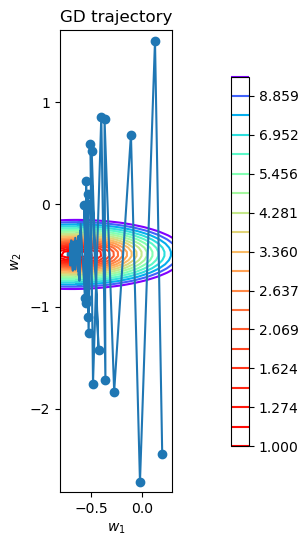

In [18]:
lr = [0.0001, 0.001, 0.01, 0.012]
batch_size = [1, 10, 100, 200]

for j in range(len(batch_size)):
    for i in range(len(lr)):
        start_time = time.time()
        w_list = stochastic_gradient_descent(w_init, X, y, loss, lr[i], batch_size[j])
        print('batch_size = ', batch_size[j], ',', 'lr = ', lr[i])
        print(" --- %s seconds ---" % (time.time() - start_time))
        plot_gd(w_list, X, y, loss)

Затухающий шаг в градиентном спуске:

$$
    \eta_t
    =
    \lambda
    \left(
        \frac{s_0}{s_0 + t}
    \right)^p
$$

Реализуем функцию `stochastic_gradient_descent` на этот раз с затухающим шагом по формуле выше. Параметр $s_0$ возьме равным 1. Параметр $p$ возьмем из нового аргумента функции `p`.

In [19]:
def stochastic_gradient_descent(w_init: np.ndarray, X: np.ndarray, y: np.ndarray,
                        loss: BaseLoss, lr: float, batch_size: int, p: float, n_iterations: int = 1000) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param p: float -- значение степени в формуле затухания длины шага
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """

    s0 = 1
    W = []

    for i in range(n_iterations):
        batch_indices = np.random.choice(X.shape[0], size=batch_size)
        X_batch = X[batch_indices]
        y_batch = y[batch_indices]
        w_init_new = w_init - lr*((s0/(s0 + i))**p)*loss.calc_grad(X_batch, y_batch, w_init)
        W.append(w_init_new)
        w_init = w_init_new

    return W

p =  0.1


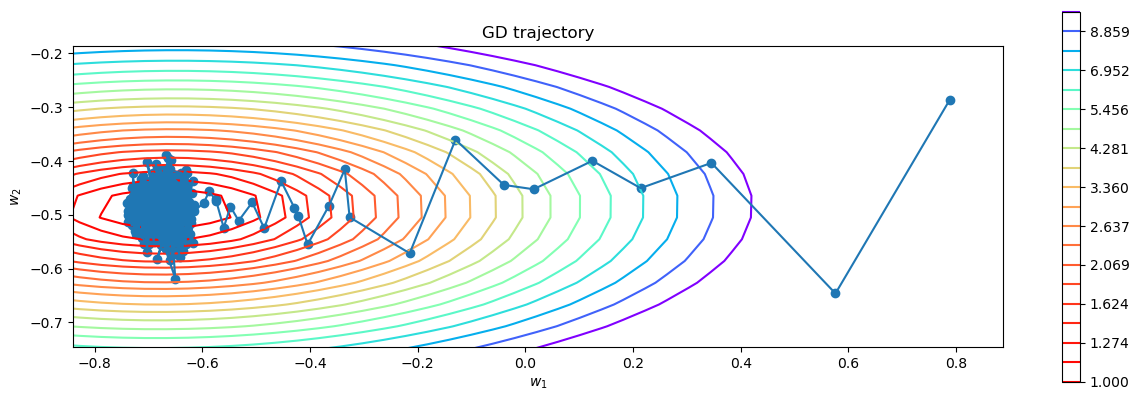

p =  0.3


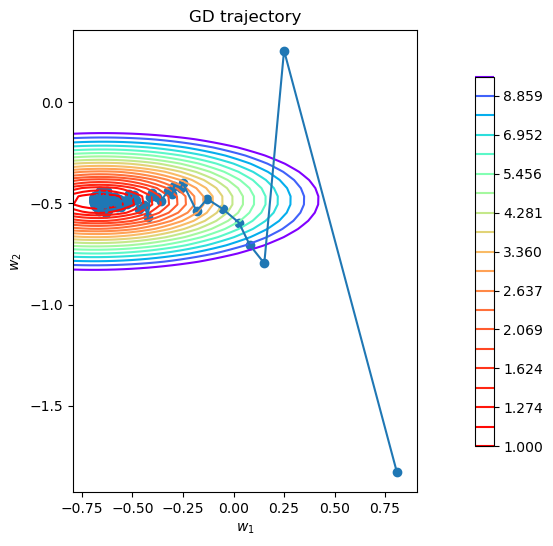

p =  0.6


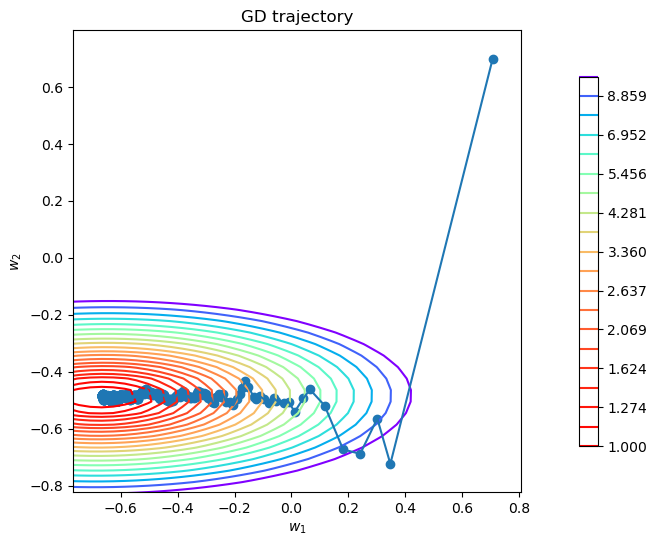

p =  0.9


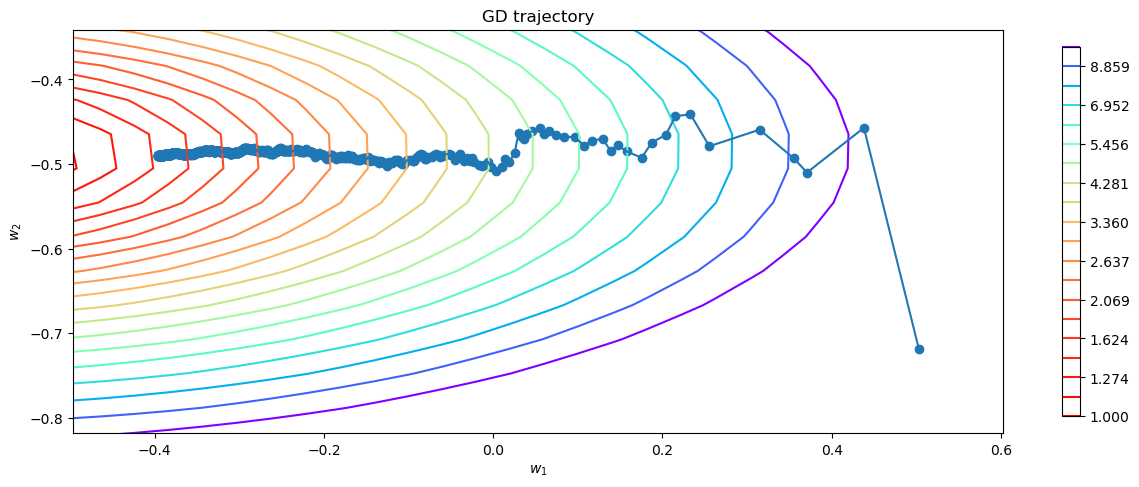

In [20]:
p = [0.1, 0.3, 0.6, 0.9]

for i in range(len(p)):
    w_list = stochastic_gradient_descent(w_init, X, y, loss, lr=0.01, batch_size=10, p = p[i])
    print('p = ', p[i])
    plot_gd(w_list, X, y, loss)

In [21]:
k_sgd = []
sgd = []
loss = MSELoss()

w_list = stochastic_gradient_descent(w_init, X, y, loss, lr=0.01, batch_size=10, p = 0.1, n_iterations=100)
for i in range(len(w_list)):
    losses_sgd = loss.calc_loss(X, y, w_list[i])
    sgd.append(losses_sgd)
    k_sgd.append(i)


k_gd = []
gd = []
loss = MSELoss()

w_list = gradient_descent(w_init, X, y, loss, 0.01, 100)
for i in range(len(w_list)):
    losses_gd = loss.calc_loss(X, y, w_list[i])
    gd.append(losses_gd)
    k_gd.append(i)

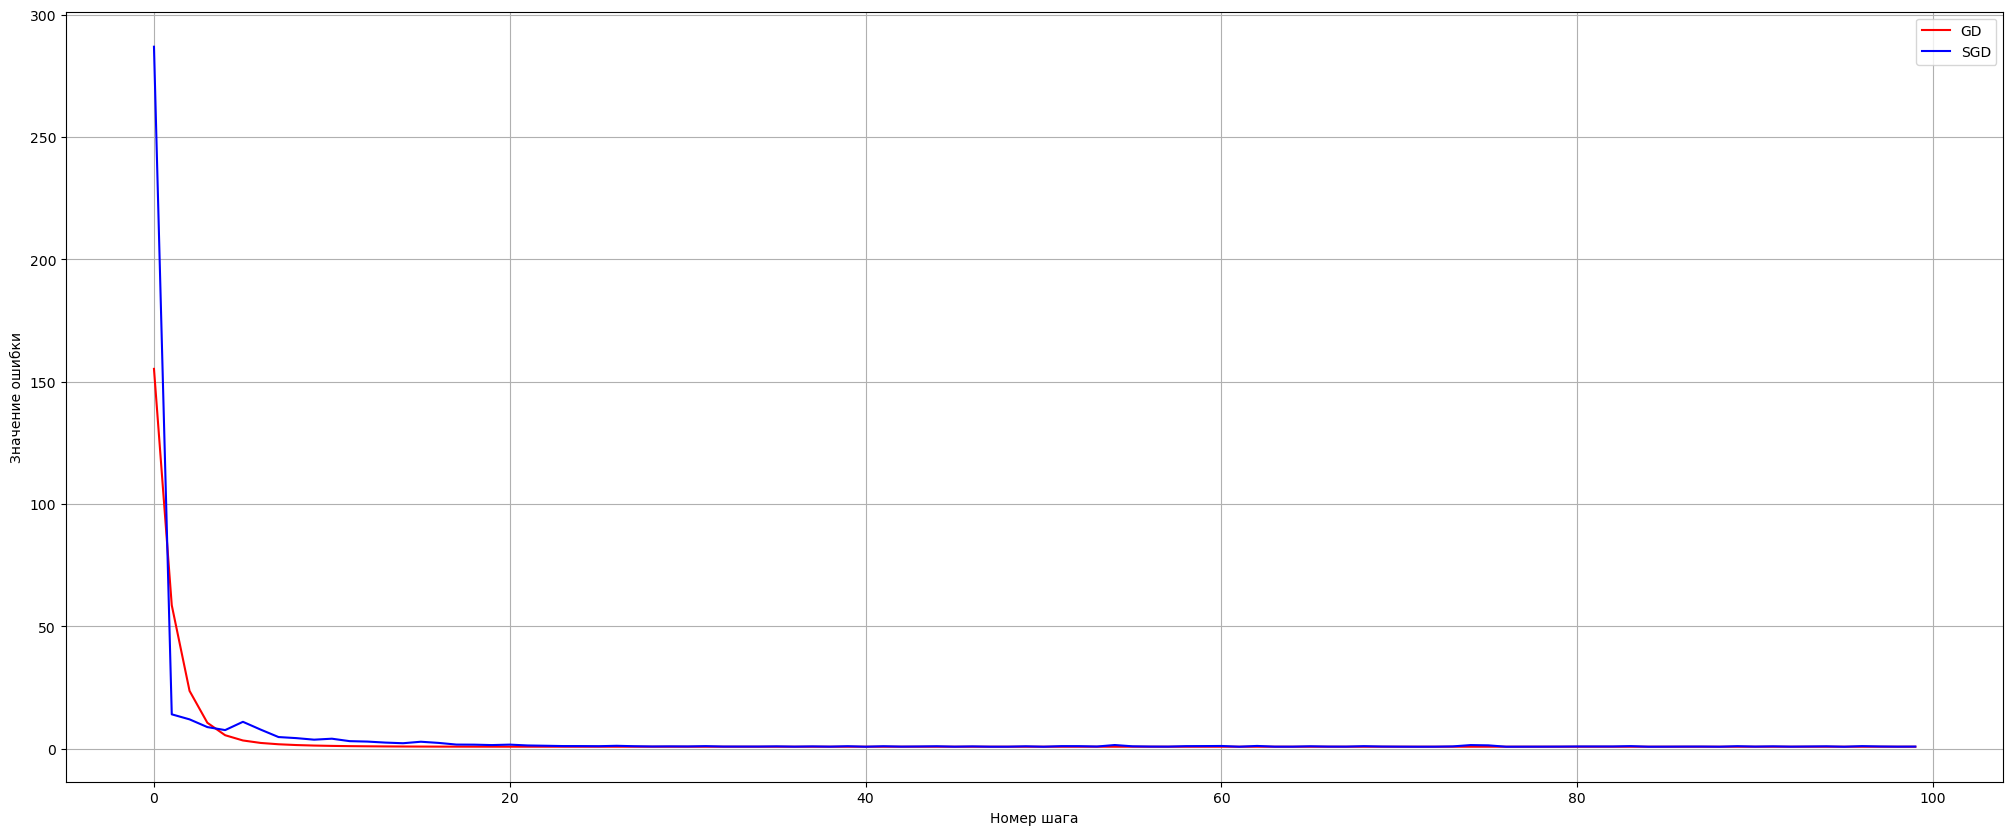

In [23]:
x1 = k_gd
x2 = k_sgd

fig, ax = plt.subplots(figsize=(25, 10))

y1 = gd
y2 = sgd

ax.plot(x1, y1, color = 'red', label = 'GD')
ax.plot(x2, y2, color = 'blue', label = 'SGD')

ax.grid(True)

plt.xlabel("Номер шага")
plt.ylabel("Значение ошибки")
plt.legend()

## Линейная регрессия

In [87]:
class LinearRegression1:
    def __init__(self, loss: BaseLoss, lr: float = 0.1) -> None:
        self.loss = loss
        self.lr = lr
        self.w = None
        self.g = None


    def fit(self, X: np.ndarray, y: np.ndarray) -> 'LinearRegression':
        X = np.asarray(X)
        y = np.asarray(y)

        # добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])
        shape_X = X.shape

        # иниц. веса
        self.w = np.arange(shape_X[-1])
        self.g = gradient_descent(self.w, X, y, self.loss, lr = self.lr, n_iterations = 100000)
        return self.g[-1]


    def predict(self, X: np.ndarray) -> np.ndarray:
        # Проверяем, что регрессия обучена, то есть, что был вызван fit и в нём был установлен атрибут self.w
        assert hasattr(self, "w"), "Linear regression must be fitted first"
        assert hasattr(self, "g"), "Linear regression must be fitted first"

        # добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])
        y = np.dot(X, self.g[-1])


        return y

In [88]:
linear_regression = LinearRegression1(MSELoss())

In [89]:
X_raw = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data",
    header=None,
    na_values=["?"]
)

In [90]:
X_raw.head(10)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0
5,2,NaN,audi,gas,std,two,sedan,fwd,front,99.8,...,136,mpfi,3.19,3.40,8.5,110.0,5500.0,19,25,15250.0
6,1,158.0,audi,gas,std,four,sedan,fwd,front,105.8,...,136,mpfi,3.19,3.40,8.5,110.0,5500.0,19,25,17710.0
7,1,NaN,audi,gas,std,four,wagon,fwd,front,105.8,...,136,mpfi,3.19,3.40,8.5,110.0,5500.0,19,25,18920.0
8,1,158.0,audi,gas,turbo,four,sedan,fwd,front,105.8,...,131,mpfi,3.13,3.40,8.3,140.0,5500.0,17,20,23875.0
9,0,NaN,audi,gas,turbo,two,hatchback,4wd,front,99.5,...,131,mpfi,3.13,3.40,7.0,160.0,5500.0,16,22,NaN


In [91]:
X_raw = X_raw[~X_raw[25].isna()].reset_index()

In [92]:
y = X_raw[25]
X_raw = X_raw.drop(25, axis=1)

In [93]:
X_raw.isnull().any().any()

True

In [94]:
X_raw.shape

(201, 26)

In [95]:
nulls = X_raw.isna().sum()
nulls = nulls[nulls > 0]
nulls

1     37
5      2
18     4
19     4
21     2
22     2
dtype: int64

In [96]:
X_raw[1] = X_raw[1].fillna(X_raw[1].mean())

In [97]:
X_raw[5].value_counts()

5
four    113
two      86
Name: count, dtype: int64

In [98]:
X_raw[5] = X_raw[5].fillna('four')

In [99]:
columns = [18,19,21,22]

for column in columns:
    print(column)
    print(mode(X_raw[column])[0])
    X_raw[column] = X_raw[column].fillna(mode(X_raw[column])[0])

18
3.62
19
3.4
21
68.0
22
4800.0


In [100]:
X_raw.isnull().any().any()

False

In [101]:
columns = [3,4,5,8]

for col in columns:
    print(X_raw[col].unique())

['gas' 'diesel']
['std' 'turbo']
['two' 'four']
['front' 'rear']


In [102]:
for col in columns:
    X_raw[col] = LabelEncoder().fit_transform(X_raw[col])

In [103]:
X_raw.head()

,index,0,1,2,3,4,5,6,7,8,...,15,16,17,18,19,20,21,22,23,24
0,0,3,122.0,alfa-romero,1,0,1,convertible,rwd,0,...,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27
1,1,3,122.0,alfa-romero,1,0,1,convertible,rwd,0,...,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27
2,2,1,122.0,alfa-romero,1,0,1,hatchback,rwd,0,...,six,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26
3,3,2,164.0,audi,1,0,0,sedan,fwd,0,...,four,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30
4,4,2,164.0,audi,1,0,0,sedan,4wd,0,...,five,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22


In [104]:
X_raw = X_raw.drop('index', axis = 1)

In [105]:
cat_mask = X_raw.select_dtypes(include=['object']).columns

In [106]:
X_raw = pd.get_dummies(X_raw, columns=cat_mask, drop_first=True)

In [107]:
X_raw.columns

Index([                0,                 1,                 3,
                       4,                 5,                 8,
                       9,                10,                11,
                      12,                13,                16,
                      18,                19,                20,
                      21,                22,                23,
                      24,          '2_audi',           '2_bmw',
           '2_chevrolet',         '2_dodge',         '2_honda',
               '2_isuzu',        '2_jaguar',         '2_mazda',
       '2_mercedes-benz',       '2_mercury',    '2_mitsubishi',
              '2_nissan',        '2_peugot',      '2_plymouth',
             '2_porsche',       '2_renault',          '2_saab',
              '2_subaru',        '2_toyota',    '2_volkswagen',
               '2_volvo',       '6_hardtop',     '6_hatchback',
               '6_sedan',         '6_wagon',           '7_fwd',
                 '7_rwd',            '14

In [108]:
X_raw.columns = X_raw.columns.astype(str)

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size = 0.3)

In [110]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [111]:
lin_reg = LinearRegression1(MSELoss(), lr=0.01)
lin_reg.fit(X_train, y_train)

array([ -374.26629463,  -464.78774107, -1657.74508483,   131.15195213,
         228.62144553,   780.23547804,  1064.5009143 , -1855.49600662,
        1221.04147444, -1443.04906773,  4047.72436568,  1179.78275431,
        -518.5740609 ,  -186.68474141, -3028.037417  ,  2194.99986968,
         793.04267544,   -80.57960327,   648.62621073,   443.31026793,
        1361.58410567,  -533.84413682, -1058.72290068,  -863.40963856,
        -472.15839432,  -297.63229978,  -491.39700437,   667.36273721,
          28.        ,  -927.46743544,  -571.16145415,  -337.63320066,
        -963.81253471,   808.23547804,   -80.5611927 ,   486.20643359,
        -351.23596525, -1226.27903088,  -328.95767858,  -707.4827988 ,
        -645.14046485, -1025.88641908,  -497.3302835 ,  -376.03572544,
        -207.37117091,   113.54688225,  -186.81191428,   989.38470461,
          36.92540985,  -747.9235612 ,   -62.68743608, -1605.53098215,
       -1752.97207077, -1547.09893264,   366.33304998,  -267.63229978,
      

In [112]:
print("MSE train: ", mean_squared_error(y_train, lin_reg.predict(X_train)))
print("MSE test: ", mean_squared_error(y_test, lin_reg.predict(X_test)))

MSE train:  1562973.3998613802
MSE test:  8246275.628570819
